In this code we take Oct 1st, 2021 - Dec31st 2024 as training and Jan 1st, 2025 - Aug 21st, 2025 as test. So we are doing a "forward regression" (FR). Can't use 'year' as feature due to overfitting, so we do detrending (DT) using year first.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#load data/AllWeathDTypes_NWPP_10yrs.csv as a dataframe
dfX = pd.read_csv("data/AllWeathDTypes_NWPP_10yrs.csv")
dfY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv")
#subtract 7 hours from datetime to convert from UTC to PST
dfY['datetime'] = pd.to_datetime(dfY['datetime'])
dfY['datetime'] = dfY['datetime'] - pd.Timedelta(hours=7)
dfX['datetime'] = pd.to_datetime(dfX['datetime'])
dfX['datetime'] = (dfX['datetime'] - pd.Timedelta(hours=7))

In [3]:
                                                                                                        `
from helpers import totalload

# Use the totalload function to calculate the total load
# if you dont mention time it will consider 12am as default
start_date = dfY[dfY['name']=='Avista Corporation'].sort_values(by='datetime').dropna()['datetime'].min()
end_date = dfY[dfY['name']=='Avista Corporation'].sort_values(by='datetime').dropna()['datetime'].max()
print(f"Data ranges from {start_date} to {end_date}")
dfY = totalload(dfY, start_date, end_date)

Data ranges from 2022-02-24 15:00:00 to 2025-08-22 05:00:00
zones added:  ['Puget Sound Energy, Inc.' 'Seattle City Light' 'Avista Corporation'
 'City of Tacoma, Department of Public Utilities'
 'Portland General Electric Company' 'PACW-TAC' 'BPA']


In [5]:
# RTL_forecast = pd.read_excel("data/8-31to9-10_RTLoad_midC.xls")
# Temp_forecast = pd.read_excel("data/8-31to9-10_Weath_midC.xlsx",skiprows=1)
# RTL_forecast['datetime'] = pd.to_datetime(RTL_forecast['datetime']) - pd.Timedelta(hours=3)
# Temp_forecast['datetime'] = pd.to_datetime(Temp_forecast['Date'])+ pd.to_timedelta(Temp_forecast['Hour'], unit='h') + pd.Timedelta(hours=1)
# Temp_forecast['Temp (F)'] = Temp_forecast['Temp (C)'] * 9/5 + 32
# Temp_forecast.rename(columns={'Temp (F)': 'temperature'}, inplace=True)

In [4]:
dfX = dfX[dfX['temperature'] >= 0]

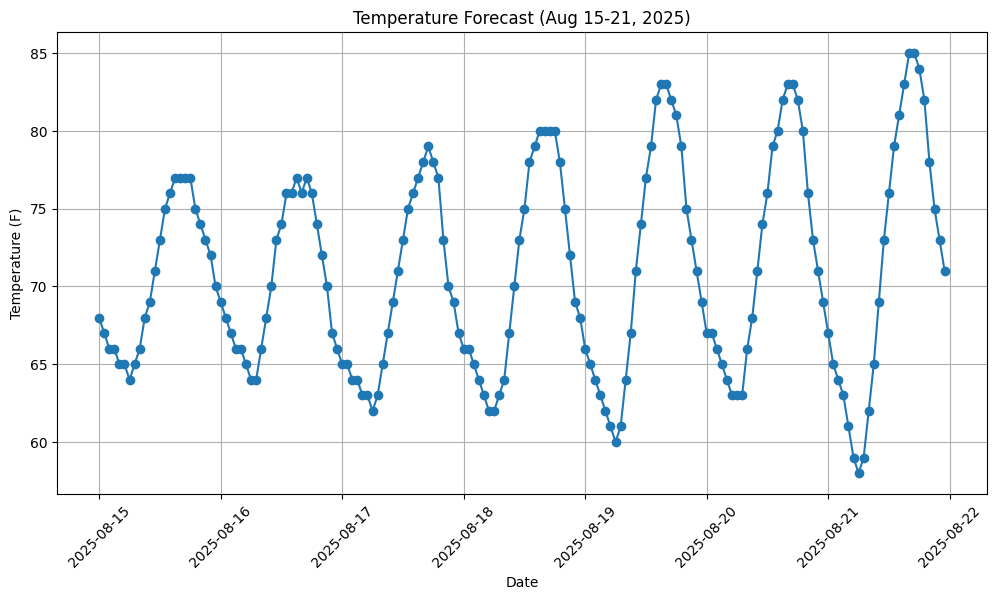

In [47]:
#plot dfY for Aug 15-21 
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(dfX[dfX['datetime'].dt.date.between(pd.to_datetime('2025-08-15').date(), pd.to_datetime('2025-08-21').date())]['datetime'], dfX[dfX['datetime'].dt.date.between(pd.to_datetime('2025-08-15').date(), pd.to_datetime('2025-08-21').date())]['temperature'], marker='o')
plt.title('Temperature Forecast (Aug 15-21, 2025)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [5]:
# Extract date and time components from the 'datetime' column
dfX['year'] = dfX['datetime'].dt.year
dfX['month'] = dfX['datetime'].dt.month
dfX['date'] = dfX['datetime'].dt.day
dfX['day'] = dfX['datetime'].dt.dayofweek
dfX['time'] = dfX['datetime'].dt.hour
# dfX['temperature_spread'] = dfX['temperature_max'] - dfX['temperature_min']

In [6]:
df_XY = pd.merge(dfX, dfY, on='datetime')

In [7]:
df_XY[['datetime','temperature_avg','temperature_max','temperature_min','weighted_cdd','weighted_hdd']].dropna()

,datetime,temperature_avg,temperature_max,temperature_min,weighted_cdd,weighted_hdd
2,2022-02-24 17:00:00,31.5,43.0,20.0,0.0,33.3
26,2022-02-25 17:00:00,35.5,45.0,26.0,0.0,29.3
50,2022-02-26 17:00:00,42.5,49.0,36.0,0.0,22.3
74,2022-02-27 17:00:00,48.0,55.0,41.0,0.0,16.9
98,2022-02-28 17:00:00,51.5,59.0,44.0,0.0,13.4
...,...,...,...,...,...,...
30481,2025-08-17 17:00:00,71.0,82.0,60.0,6.2,0.0
30505,2025-08-18 17:00:00,71.5,84.0,59.0,6.7,0.1
30529,2025-08-19 17:00:00,72.5,84.0,61.0,7.5,0.0
30553,2025-08-20 17:00:00,71.5,86.0,57.0,6.5,0.3


In [ ]:
# Get the columns we want to fill
columns_to_fill = ['temperature_avg', 'temperature_max', 'temperature_min', 'weighted_cdd', 'weighted_hdd']

# Group by date and forward fill the values
df_XY['date_key'] = df_XY['datetime'].dt.date
df_17 = df_XY[df_XY['datetime'].dt.hour == 17][['date_key'] + columns_to_fill]

# Merge the 17:00 values with the main dataframe
df_XY = df_XY.merge(df_17, on='date_key', how='left', suffixes=('', '_17'))

# Replace NaN values in original columns with values from 17:00
for col in columns_to_fill:
    df_XY[col] = df_XY[col].fillna(df_XY[f'{col}_17'])
    df_XY = df_XY.drop(f'{col}_17', axis=1)

# Drop the temporary date_key column
df_XY = df_XY.drop('date_key', axis=1)

In [7]:
#print latest datetime in df_XY
print("Latest datetime in df_XY:", df_XY['datetime'].max())

Latest datetime in df_XY: 2025-08-22 05:00:00


In [12]:
df_XY.tail()

,datetime,cloudCover,dewpoint,electric_cdd,electric_hdd,gas_cdd,gas_hdd,heatIndex,population_cdd,population_hdd,...,weighted_hdd,windChill,windDirection,windSpeed,year,month,date,day,time,Total Load
30618,2025-08-22 19:00:00,14.0,45.0,NaN,NaN,NaN,NaN,87.0,NaN,NaN,...,NaN,90.0,4.0,9.0,2025,8,22,4,19,0.0
30619,2025-08-22 20:00:00,19.0,50.0,NaN,NaN,NaN,NaN,82.0,NaN,NaN,...,NaN,84.0,357.0,6.0,2025,8,22,4,20,0.0
30620,2025-08-22 21:00:00,14.0,50.0,NaN,NaN,NaN,NaN,79.0,NaN,NaN,...,NaN,79.0,347.0,7.0,2025,8,22,4,21,0.0
30621,2025-08-22 22:00:00,9.0,50.0,NaN,NaN,NaN,NaN,78.0,NaN,NaN,...,NaN,78.0,346.0,8.0,2025,8,22,4,22,0.0
30622,2025-08-22 23:00:00,9.0,50.0,NaN,NaN,NaN,NaN,75.0,NaN,NaN,...,NaN,75.0,21.0,8.0,2025,8,22,4,23,0.0


Year coefficient: 190.69, Intercept: -368653.21
Training data shape: (24993, 4), Test data shape: (5597, 4)

R-squared on training data: 0.9471
R-squared on test data: 0.9410
Mean Absolute Percentage Error on training data: 2.99%
Mean Absolute Percentage Error on test data: 3.13%


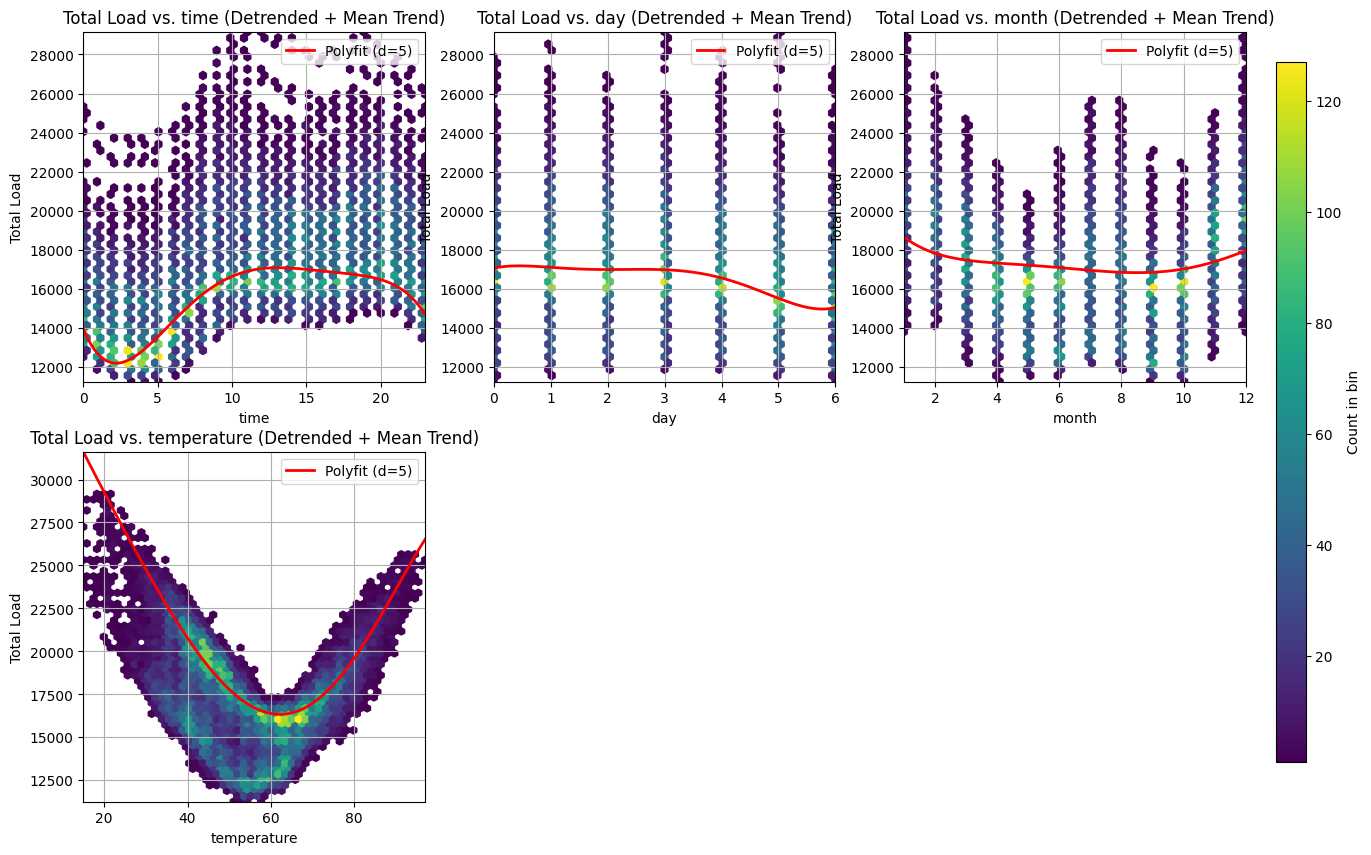

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

import matplotlib.pyplot as plt

# 1. Feature Engineering and Selection
features = ['time', 'day', 'month','temperature']
target = 'Total Load'

X = df_XY[features]
y = df_XY[target]

# Define train/test split based on year
train_mask = df_XY['year'] < 2025
test_mask = df_XY['year'] == 2025

# Detrend the target variable based on year, fitting only on training data
X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
y_train_for_trend = y[train_mask]

trend_model = LinearRegression()
trend_model.fit(X_year_train, y_train_for_trend)
print(f"Year coefficient: {trend_model.coef_[0]:.2f}, Intercept: {trend_model.intercept_:.2f}")

# Calculate residuals for all data using the trend model fitted on training data only
X_year = df_XY[['year']].astype(float)
y_trend = trend_model.predict(X_year)
y_residuals = y - y_trend

# 2. Split data into training and testing sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train_residuals = y_residuals[train_mask]
y_test_residuals = y_residuals[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
y_train_trend = y_trend[train_mask]
y_test_trend = y_trend[test_mask]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Polynomial Regression on residuals
poly_degree = 5
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model on residuals
model = LinearRegression()
model.fit(X_train_poly, y_train_residuals)

# Make predictions on residuals
y_train_residuals_pred = model.predict(X_train_poly)
y_test_residuals_pred = model.predict(X_test_poly)

# Add trend back to get final predictions
y_train_pred = y_train_residuals_pred + y_train_trend
y_test_pred = y_test_residuals_pred + y_test_trend

# Calculate R² on the actual values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f"Mean Absolute Percentage Error on training data: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on test data: {mape_test:.2f}%")

# 6. Visualization
# Create a figure with subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Calculate mean trend value to add back
mean_trend = y_train_trend.mean()

# To plot the effect of each feature, we hold other features at their mean
X_train_scaled_mean = X_train_scaled.mean(axis=0)

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Generate a range of values for the current feature
    feature_col_index = X_train.columns.get_loc(feature)
    feature_range_scaled = np.linspace(X_train_scaled[:, feature_col_index].min(), X_train_scaled[:, feature_col_index].max(), 100)
    
    # Create a test set where only the current feature varies
    plot_X_scaled = np.tile(X_train_scaled_mean, (100, 1))
    plot_X_scaled[:, feature_col_index] = feature_range_scaled
    
    # Transform for polynomial prediction
    plot_X_poly = poly.transform(plot_X_scaled)
    
    # Predict residuals and add back mean trend
    y_pred_plot_residuals = model.predict(plot_X_poly)
    y_pred_plot = y_pred_plot_residuals + mean_trend
    
    # Inverse transform the feature values to their original scale for plotting
    feature_range_original = scaler.inverse_transform(plot_X_scaled)[:, feature_col_index]
    
    # Sort values for a smooth line plot
    sort_indices = np.argsort(feature_range_original)
    
    # Density plot (hexbin) of detrended data with mean trend added back
    hb = ax.hexbin(X_train[feature], y_train_residuals + mean_trend, gridsize=50, cmap='viridis', mincnt=1)
    
    # Plot the polynomial curve with mean trend added back
    ax.plot(feature_range_original[sort_indices], y_pred_plot[sort_indices], color='red', linewidth=2, label=f'Polyfit (d={poly_degree})')
    
    # Set x and y limits based on the data range
    y_min = min((y_train_residuals + mean_trend).min(), y_pred_plot.min())
    y_max = max((y_train_residuals + mean_trend).max(), y_pred_plot.max())
    ax.set_xlim(X_train[feature].min(), X_train[feature].max())
    ax.set_ylim(y_min, y_max)
    
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs. {feature} (Detrended + Mean Trend)')
    ax.legend()
    ax.grid(True)

# Add a common colorbar for all hexbin plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='Count in bin')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()

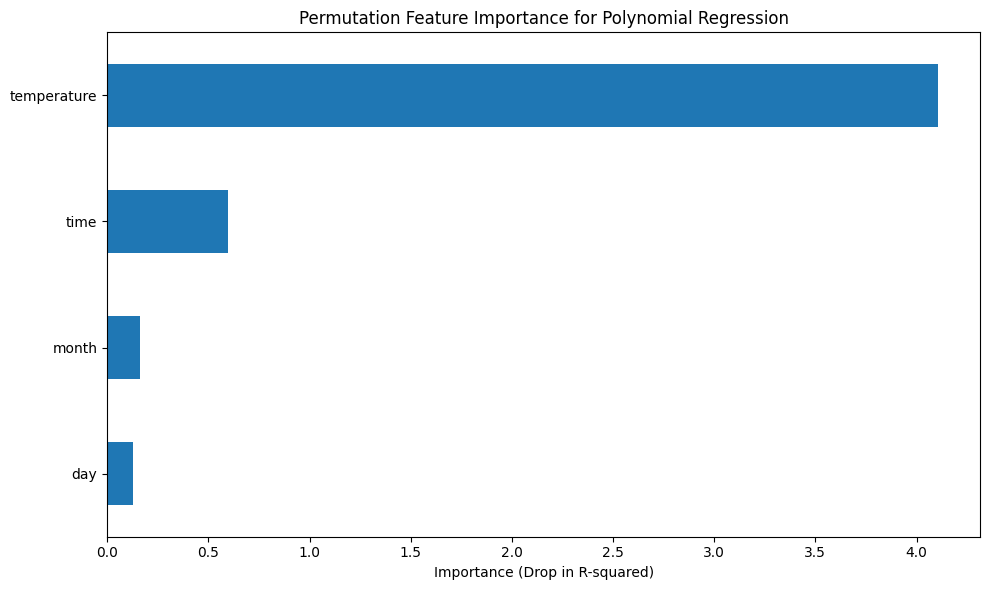

Feature Importances (summed from polynomial terms):
temperature    4.108295
time           0.596878
month          0.164058
day            0.125519
dtype: float64


In [18]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on the test set
# We use the test set to see how important features are for making predictions on unseen data.
# The polynomial features (X_test_poly) and corresponding target values (y_test) are used.
result = permutation_importance(
    model, X_test_poly, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# The result gives importance for each polynomial feature. We need to map this back to the original features.
# We can do this by summing the importances of all polynomial terms that include a given original feature.
original_feature_importance = np.zeros(len(features))
poly_feature_names = poly.get_feature_names_out(features)

for i, feature in enumerate(features):
    # Find all polynomial features that contain the original feature
    indices = [j for j, name in enumerate(poly_feature_names) if feature in name.split()]
    # Sum the importances of these polynomial features
    original_feature_importance[i] = result.importances_mean[indices].sum()

# Create a pandas Series for easier plotting and viewing
importance_df = pd.Series(original_feature_importance, index=features)

# Sort the features by importance
sorted_importance = importance_df.sort_values(ascending=True)

# Plotting the feature importances
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importance.plot(kind='barh', ax=ax)
ax.set_title('Permutation Feature Importance for Polynomial Regression')
ax.set_xlabel('Importance (Drop in R-squared)')
plt.tight_layout()
plt.show()

print("Feature Importances (summed from polynomial terms):")
print(sorted_importance.sort_values(ascending=False))

In [19]:
# Predict on the test data
y_pred_test = model.predict(X_test_poly)

# Create a new dataframe with the test data, actual load, and predicted load
df_results = X_test.copy()
df_results['Actual Load'] = y_test
df_results['Predicted Load'] = y_pred_test

# Display the first few rows of the results dataframe
df_results.head(30)

,time,day,month,temperature,Actual Load,Predicted Load
24993,0,2,1,37.0,18830.250000,19440.253331
24994,1,2,1,37.0,18175.333333,17397.087294
24995,2,2,1,37.0,17605.000000,16481.955552
24996,3,2,1,36.0,17302.250000,16595.046071
24997,4,2,1,36.0,17066.833333,17030.902780
24998,5,2,1,36.0,17028.666667,17805.752914
24999,6,2,1,36.0,17240.666667,18747.829757
25000,7,2,1,36.0,17862.500000,19726.196298
25001,8,2,1,36.0,18634.916667,20646.214927
25002,9,2,1,37.0,19200.250000,21167.921290


In [20]:
#find average load and the mean absolute error
df_results['Absolute Error'] = np.abs(df_results['Actual Load'] - df_results['Predicted Load'])
average_load = df_results['Actual Load'].mean()
mean_absolute_error = df_results['Absolute Error'].mean()
error_percentage = (mean_absolute_error / average_load) * 100

print("Average Load:", average_load)
print("Mean Absolute Error:", mean_absolute_error)
print("Error Percentage:", error_percentage)


Average Load: 17769.905965138823
Mean Absolute Error: 663.3274613222657
Error Percentage: 3.7328698453643367


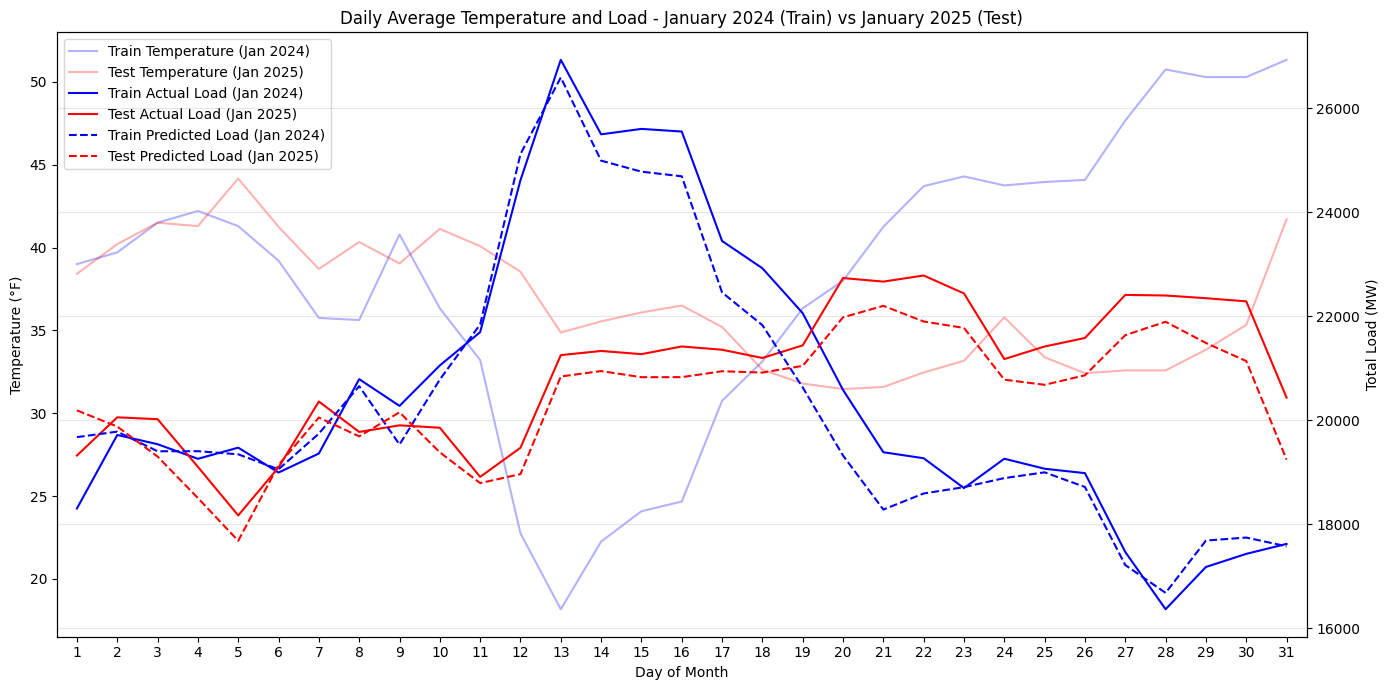

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Filter df_XY for January 2024 and January 2025
jan_2024_data = df_XY[(df_XY['year'] == 2024) & (df_XY['month'] == 1)].copy()
jan_2025_data = df_XY[(df_XY['year'] == 2025) & (df_XY['month'] == 1)].copy()

# Add predicted values
# For January 2025, we can use df_results
jan_2025_data['Predicted Load'] = df_results[df_results['month'] == 1]['Predicted Load'].values



# For January 2024, we need to predict
X_2024 = jan_2024_data[features]
X_2024_scaled = scaler.transform(X_2024)
X_2024_poly = poly.transform(X_2024_scaled)
jan_2024_data['Predicted Load'] = model.predict(X_2024_poly)

# Add set column
jan_2024_data['set'] = 'train'
jan_2025_data['set'] = 'test'

# Group by date to get daily averages
train_daily = jan_2024_data.groupby('date').agg({
    'temperature': 'mean',
    'Total Load': 'mean',
    'Predicted Load': 'mean'
}).reset_index()

test_daily = jan_2025_data.groupby('date').agg({
    'temperature': 'mean',
    'Total Load': 'mean',
    'Predicted Load': 'mean'
}).reset_index()

# Create a figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot temperature on primary y-axis
ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Temperature (°F)', color='black')
ax1.plot(train_daily['date'], train_daily['temperature'], color='blue', alpha=0.3, label='Train Temperature (Jan 2024)')
ax1.plot(test_daily['date'], test_daily['temperature'], color='red', alpha=0.3, label='Test Temperature (Jan 2025)')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis for loads
ax2 = ax1.twinx()
ax2.set_ylabel('Total Load (MW)', color='black')

# Plot actual loads
ax2.plot(train_daily['date'], train_daily['Total Load'], color='blue', label='Train Actual Load (Jan 2024)')
ax2.plot(test_daily['date'], test_daily['Total Load'], color='red', label='Test Actual Load (Jan 2025)')

# Plot predicted loads (dashed lines)
ax2.plot(train_daily['date'], train_daily['Predicted Load'], color='blue', linestyle='--', label='Train Predicted Load (Jan 2024)')
ax2.plot(test_daily['date'], test_daily['Predicted Load'], color='red', linestyle='--', label='Test Predicted Load (Jan 2025)')

# Set x-axis to show all days
ax1.set_xticks(range(1, 32))
ax1.set_xlim(0.5, 31.5)

# Add title and legend
plt.title('Daily Average Temperature and Load - January 2024 (Train) vs January 2025 (Test)')

# Create legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')



plt.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

Using 18 features: ['cloudCover', 'dewpoint', 'heatIndex', 'relativeHumidity', 'temperature', 'temperature_avg', 'temperature_max', 'temperature_min', 'weighted_cdd', 'weighted_hdd', 'windChill', 'windDirection', 'windSpeed', 'year', 'month', 'date', 'day', 'time']
Year coefficient: 190.69, Intercept: -368653.21
Training data shape: (24993, 18), Test data shape: (5597, 18)

R-squared on training data: 0.9788
R-squared on test data: 0.9611
Mean Absolute Percentage Error on training data: 1.83%
Mean Absolute Percentage Error on test data: 2.47%


<Figure size 1200x800 with 0 Axes>

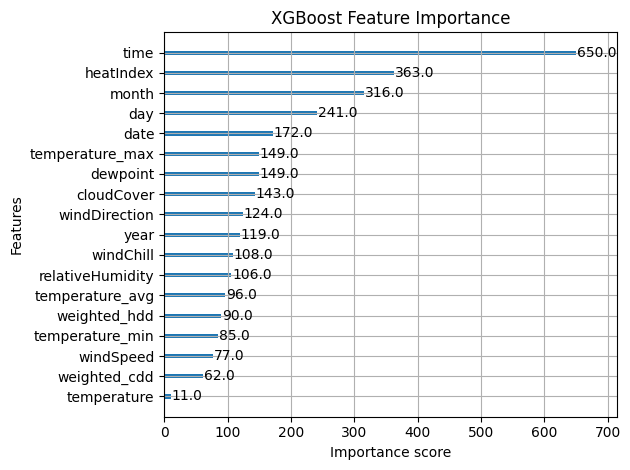

In [14]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression

# 1. Feature Engineering and Selection - use all columns except the target and non-feature columns
target = 'Total Load'
exclude_cols = [target, 'Predicted Load', 'set', 'datetime', 'electric_cdd', 'electric_hdd', 'gas_cdd', 'gas_hdd', 'population_cdd', 'population_hdd']

# Get all feature columns
features = [col for col in df_XY.columns if col not in exclude_cols]
print(f"Using {len(features)} features: {features}")

X = df_XY[features]
y = df_XY[target]

# Define train/test split based on year
train_mask = df_XY['year'] < 2025
test_mask = df_XY['year'] == 2025

# Detrend the target variable based on year, fitting only on training data
X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
y_train_for_trend = y[train_mask]

trend_model = LinearRegression()
trend_model.fit(X_year_train, y_train_for_trend)
print(f"Year coefficient: {trend_model.coef_[0]:.2f}, Intercept: {trend_model.intercept_:.2f}")

# Calculate residuals for all data using the trend model fitted on training data only
X_year = df_XY[['year']].astype(float)
y_trend = trend_model.predict(X_year)
y_residuals = y - y_trend

# 2. Split data into training and testing sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train_residuals = y_residuals[train_mask]
y_test_residuals = y_residuals[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
y_train_trend = y_trend[train_mask]
y_test_trend = y_trend[test_mask]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# 3. Handle missing values
# Fill numeric columns with their median values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use training medians for test data

# 4. XGBoost model on residuals
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'reg:squarederror'
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train_residuals)

# Make predictions on residuals
y_train_residuals_pred = model.predict(X_train)
y_test_residuals_pred = model.predict(X_test)

# Add trend back to get final predictions
y_train_pred = y_train_residuals_pred + y_train_trend
y_test_pred = y_test_residuals_pred + y_test_trend

# Calculate R² on the actual values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# Calculate MAPE
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f"Mean Absolute Percentage Error on training data: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on test data: {mape_test:.2f}%")

# 6. Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


Using 18 features: ['cloudCover', 'dewpoint', 'heatIndex', 'relativeHumidity', 'temperature', 'temperature_avg', 'temperature_max', 'temperature_min', 'weighted_cdd', 'weighted_hdd', 'windChill', 'windDirection', 'windSpeed', 'year', 'month', 'date', 'day', 'time']
Year coefficient: 190.69, Intercept: -368653.21
Training data shape: (24993, 18), Test data shape: (5597, 18)

R-squared on training data: 0.9776
R-squared on test data: 0.9625
Mean Absolute Percentage Error on training data: 1.90%
Mean Absolute Percentage Error on test data: 2.44%


<Figure size 1200x800 with 0 Axes>

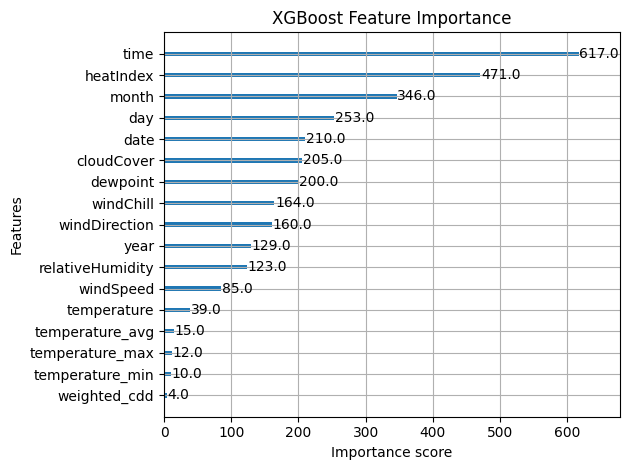

In [8]:
# if i dont use 'electric_cdd', 'electric_hdd', 'gas_cdd', 'gas_hdd', 'population_cdd', 'population_hdd' as features, the model performs slightly better
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression

# 1. Feature Engineering and Selection - use all columns except the target and non-feature columns
target = 'Total Load'
exclude_cols = [target, 'Predicted Load', 'set', 'datetime', 'electric_cdd', 'electric_hdd', 'gas_cdd', 'gas_hdd', 'population_cdd', 'population_hdd']

# Get all feature columns
features = [col for col in df_XY.columns if col not in exclude_cols]
print(f"Using {len(features)} features: {features}")

X = df_XY[features]
y = df_XY[target]

# Define train/test split based on year
train_mask = df_XY['year'] < 2025
test_mask = df_XY['year'] == 2025

# Detrend the target variable based on year, fitting only on training data
X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
y_train_for_trend = y[train_mask]

trend_model = LinearRegression()
trend_model.fit(X_year_train, y_train_for_trend)
print(f"Year coefficient: {trend_model.coef_[0]:.2f}, Intercept: {trend_model.intercept_:.2f}")

# Calculate residuals for all data using the trend model fitted on training data only
X_year = df_XY[['year']].astype(float)
y_trend = trend_model.predict(X_year)
y_residuals = y - y_trend

# 2. Split data into training and testing sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train_residuals = y_residuals[train_mask]
y_test_residuals = y_residuals[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
y_train_trend = y_trend[train_mask]
y_test_trend = y_trend[test_mask]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# 3. Handle missing values
# Fill numeric columns with their median values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use training medians for test data

# 4. XGBoost model on residuals
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'reg:squarederror'
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train_residuals)

# Make predictions on residuals
y_train_residuals_pred = model.predict(X_train)
y_test_residuals_pred = model.predict(X_test)

# Add trend back to get final predictions
y_train_pred = y_train_residuals_pred + y_train_trend
y_test_pred = y_test_residuals_pred + y_test_trend

# Calculate R² on the actual values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# Calculate MAPE
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f"Mean Absolute Percentage Error on training data: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on test data: {mape_test:.2f}%")

# 6. Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()



In [18]:
import joblib
#save model and scaler as a dictionary
model_and_scaler = {
    'model': model,
    'scaler': scaler,
    'poly': poly
}
joblib.dump(model_and_scaler, 'models/Reg1modelscalerpoly.pkl')


['models/Reg1modelscalerpoly.pkl']


R-squared on training data: 0.9507
R-squared on test data: 0.9493


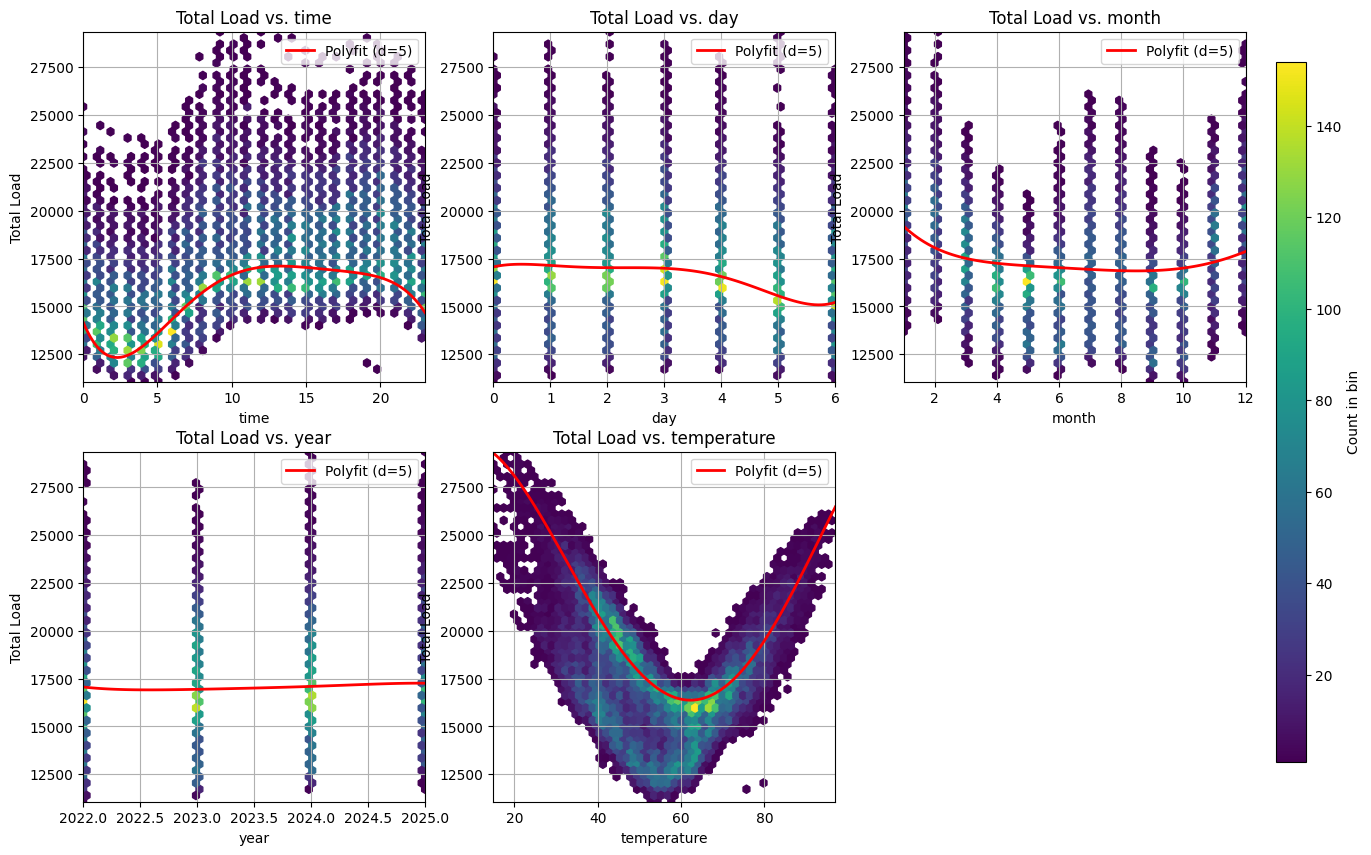

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# 1. Feature Engineering and Selection
features = ['time', 'day', 'month', 'year', 'temperature']
target = 'Total Load'

X = df_XY[features]
y = df_XY[target]

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Polynomial Regression
poly_degree = 5
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)


train_r2 = model.score(X_train_poly, y_train)
test_r2 = model.score(X_test_poly, y_test)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# 6. Visualization
# Create a figure with subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# To plot the effect of each feature, we hold other features at their mean
X_train_scaled_mean = X_train_scaled.mean(axis=0)

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Generate a range of values for the current feature
    feature_col_index = X_train.columns.get_loc(feature)
    feature_range_scaled = np.linspace(X_train_scaled[:, feature_col_index].min(), X_train_scaled[:, feature_col_index].max(), 100)
    
    # Create a test set where only the current feature varies
    plot_X_scaled = np.tile(X_train_scaled_mean, (100, 1))
    plot_X_scaled[:, feature_col_index] = feature_range_scaled
    
    # Transform for polynomial prediction
    plot_X_poly = poly.transform(plot_X_scaled)
    
    # Predict
    y_pred_plot = model.predict(plot_X_poly)
    
    # Inverse transform the feature values to their original scale for plotting
    feature_range_original = scaler.inverse_transform(plot_X_scaled)[:, feature_col_index]
    
    # Sort values for a smooth line plot
    sort_indices = np.argsort(feature_range_original)
    
    # Density plot (hexbin) of original data
    hb = ax.hexbin(X_train[feature], y_train, gridsize=50, cmap='viridis', mincnt=1)
    
    # Plot the polynomial curve
    ax.plot(feature_range_original[sort_indices], y_pred_plot[sort_indices], color='red', linewidth=2, label=f'Polyfit (d={poly_degree})')
    
    # Set x and y limits based on the data range
    ax.set_xlim(X_train[feature].min(), X_train[feature].max())
    ax.set_ylim(y_train.min(), y_train.max())
    
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs. {feature}')
    ax.legend()
    ax.grid(True)

# Add a common colorbar for all hexbin plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='Count in bin')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()

In [9]:
# Predict on the test data
y_pred_test = model.predict(X_test_poly)

# Create a new dataframe with the test data, actual load, and predicted load
df_results = X_test.copy()
df_results['Actual Load'] = y_test
df_results['Predicted Load'] = y_pred_test

# Display the first few rows of the results dataframe
print(df_results[df_results['month']==8].head(30))
#find average load and the mean absolute error
df_results['Absolute Error'] = np.abs(df_results['Actual Load'] - df_results['Predicted Load'])
average_load = df_results['Actual Load'].mean()
mean_absolute_error = df_results['Absolute Error'].mean()
error_percentage = (mean_absolute_error / average_load) * 100

print("Average Load:", average_load)
print("Mean Absolute Error:", mean_absolute_error)
print("Error Percentage:", error_percentage)

       time  day  month  year  temperature   Actual Load  Predicted Load
30270     7    2      8  2025         66.0  16622.833333    15921.885485
4120     16    4      8  2022         82.0  21048.500000    19634.673954
12896     8    6      8  2023         62.0  13025.000000    13484.662674
30357    22    5      8  2025         67.0  17035.666667    16462.018911
21661    13    0      8  2024         76.0  17635.916667    18259.599299
3778     10    4      8  2022         69.0  16293.000000    16380.790234
4391     23    1      8  2022         75.0  17833.416667    19042.589673
21890     2    3      8  2024         57.0  12885.750000    12534.817971
13083     3    0      8  2023         65.0  12692.750000    12710.412860
12806    14    2      8  2023         90.0  23951.750000    22690.672556
30287     0    3      8  2025         69.0  17091.833333    16923.826956
12525    21    4      8  2023         75.0  18897.083333    19091.266192
12715    19    5      8  2023         82.0  20151.5

In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import xgboost as xgb

# 1. Feature Engineering and Selection - use all columns except the target and non-feature columns
target = 'Total Load'
exclude_cols = [target, 'Predicted Load', 'set', 'datetime']

# Get all feature columns
features = [col for col in df_XY.columns if col not in exclude_cols]
print(f"Using {len(features)} features: {features}")

X = df_XY[features]
y = df_XY[target]

# 2. Split data into training and testing sets based on year
X_train = X[df_XY['year'] < 2025]
X_test = X[df_XY['year'] == 2025]
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# 3. Handle missing values
# Fill numeric columns with their median values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use training medians for test data

# 4. XGBoost model
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'reg:squarederror'
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# 5. Evaluate model
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# Calculate predictions
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Calculate MAPE
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f"Mean Absolute Percentage Error on training data: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on test data: {mape_test:.2f}%")

# 6. Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


Prediction on forecast data


In [18]:
#import data\8-31to9-10_RTLoad_midC.xls and data\8-31to9-10_Weath_midC.xls
RTL_forecast = pd.read_excel("data/8-31to9-10_RTLoad_midC.xls")
Temp_forecast = pd.read_excel("data/8-31to9-10_Weath_midC.xlsx",skiprows=1)

In [19]:
# Prepare features and target for prediction on forecast data

# Ensure datetime columns are in datetime format
RTL_forecast['datetime'] = pd.to_datetime(RTL_forecast['datetime']) - pd.Timedelta(hours=3)
Temp_forecast['datetime'] = pd.to_datetime(Temp_forecast['Date'])+ pd.to_timedelta(Temp_forecast['Hour'], unit='h') - pd.Timedelta(hours=0)
# Merge Temp_forecast and RTL_forecast on date and hour
Temp_forecast['time'] = Temp_forecast['Hour']
Temp_forecast['year'] = Temp_forecast['datetime'].dt.year
Temp_forecast['month'] = Temp_forecast['datetime'].dt.month
Temp_forecast['day'] = Temp_forecast['datetime'].dt.dayofweek


# Merge temperature and load forecasts on datetime
df_forecast = pd.merge(Temp_forecast, RTL_forecast, on='datetime', how='inner')
#rename Temp (C) column to temperature
#convert "temp (C)" column values fro celcius to fahrenheit
df_forecast['Temp (C)'] = df_forecast['Temp (C)'] * 9/5 + 32
df_forecast.rename(columns={'Temp (C)': 'temperature', 'Total': 'Total Load'}, inplace=True)
#drop nans from ['time', 'day', 'month', 'year', 'temperature', 'Total Load']
df_forecast = df_forecast.dropna(subset=['time', 'day', 'month', 'year', 'temperature', 'Total Load'])
# Prepare features and target
X_forecast = df_forecast[['time', 'day', 'month', 'year', 'temperature']]
y_forecast = df_forecast['Total Load']

In [17]:
df_forecast.tail()

,Date,Hour,temperature,Dew Point (C),Wind Chill (C),Heat Index (C),Wind Speed (kph),Wind Dir,RH,Cloud Cover,...,month,day,Avista Corporation (RTLOAD) Average,"City of Tacoma, Department of Public Utilities (RTLOAD) Average","Puget Sound Energy, Inc. (RTLOAD) Average",Seattle City Light (RTLOAD) Average,Portland General Electric Company (RTLOAD) Average,BPA (RTLOAD) Average,PACW-TAC (RTLOAD) Average,Total Load
273,2025-09-11,9,62.96,11.0,17.2,17.2,9.5,224.244995,74,0.77,...,9,3,1208.0,436.0,2567.0,993.0,2708.0,6440.166667,2395.0,16747.166667
274,2025-09-11,10,64.22,11.0,17.9,17.9,10.5,213.951004,71,0.76,...,9,3,1239.0,447.0,2611.0,1015.0,2742.0,6470.166667,2429.0,16953.166667
275,2025-09-11,11,65.48,10.9,18.6,18.6,10.7,244.860992,69,0.76,...,9,3,1297.0,455.0,2633.0,1024.0,2760.0,6499.666667,2443.0,17111.666667
276,2025-09-11,12,67.28,10.4,19.6,19.6,10.1,200.994995,64,0.74,...,9,3,1356.0,462.0,2643.0,1032.0,2761.0,6541.500000,2461.0,17256.500000
277,2025-09-11,13,69.08,10.2,20.6,20.6,9.4,196.843994,59,0.73,...,9,3,NaN,NaN,NaN,NaN,NaN,6578.583333,NaN,NaN


NameError: name 'august_data' is not defined

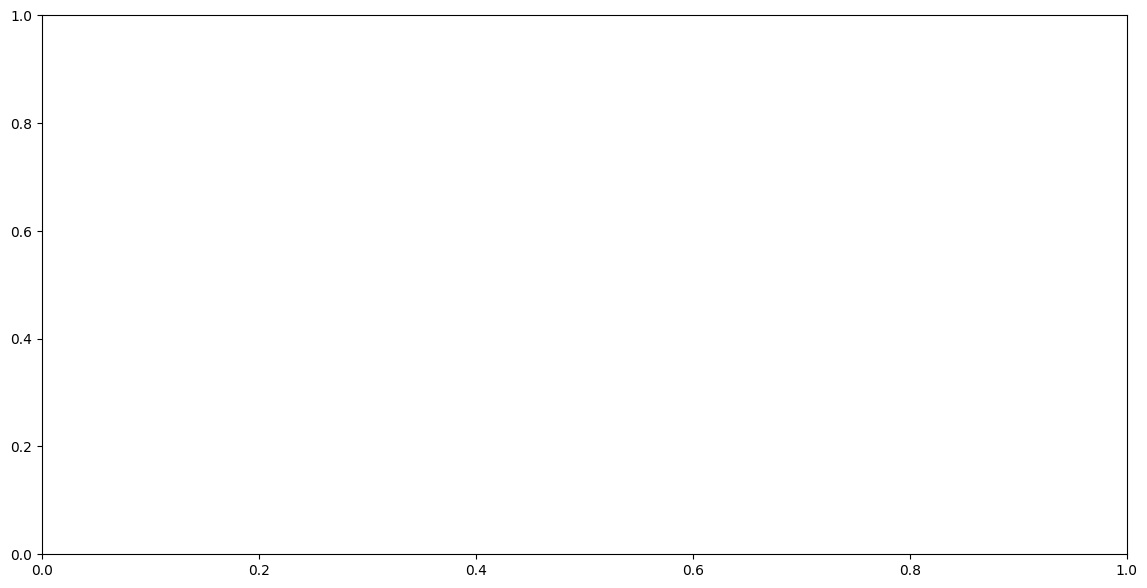

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot August and September forecast data for comparison
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot temperature for August
ax1.plot(august_data['datetime'], august_data['temperature'], color='tab:red', label='August Temperature')
# Plot temperature for September
ax1.plot(september_data['datetime'], september_data['temperature'], color='tab:orange', label='September Temperature')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°F)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary y-axis for Total Load
ax2 = ax1.twinx()
ax2.plot(august_data['datetime'], august_data['Total Load'], color='tab:blue', label='August Total Load')
ax2.plot(september_data['datetime'], september_data['Total Load'], color='tab:cyan', label='September Total Load')
ax2.set_ylabel('Total Load (MW)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# Title and legends
plt.title('Temperature and Total Load: August vs September 2025')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()

In [16]:
#tell me number of nans in y_forecast
y_forecast.isna().sum()

np.int64(1)

In [20]:


# Standardize and transform features
X_forecast_scaled = scaler.transform(X_forecast)
X_forecast_poly = poly.transform(X_forecast_scaled)

# Make predictions
y_pred_forecast = model.predict(X_forecast_poly)

# Calculate error metrics
mae = np.mean(np.abs(y_forecast - y_pred_forecast))
avg_load = y_forecast.mean()
mae_pct = (mae / avg_load) * 100
r2 = r2_score(y_forecast, y_pred_forecast)

print(f"Forecast MAE: {mae:.2f}")
print(f"Forecast MAE / Avg Load: {mae_pct:.2f}%")
print(f"Forecast R2: {r2:.4f}")

Forecast MAE: 723.58
Forecast MAE / Avg Load: 4.30%
Forecast R2: 0.8628


In [21]:
#construct df_results_forecast
df_results_forecast = X_forecast.copy()
df_results_forecast['Actual Load'] = y_forecast
df_results_forecast['Predicted Load'] = y_pred_forecast
df_results_forecast['Absolute Error'] = np.abs(df_results_forecast['Actual Load'] - df_results_forecast['Predicted Load'])

In [22]:
df_results_forecast.head()

,time,day,month,year,temperature,Actual Load,Predicted Load,Absolute Error
0,0,6,8,2025,64.76,15117.583333,15734.331735,616.748402
1,1,6,8,2025,63.32,14262.750000,14004.683412,258.066588
2,2,6,8,2025,62.96,13631.250000,13171.880899,459.369101
3,3,6,8,2025,62.42,13205.833333,12817.813897,388.019436
4,4,6,8,2025,61.52,12949.583333,12758.015296,191.568037


In [34]:
Temp_forecast

,Date,Hour,Temp (C),Dew Point (C),Wind Chill (C),Heat Index (C),Wind Speed (kph),Wind Dir,RH,Cloud Cover,Precip (in),time,year,month,day,datetime
0,2025-08-31,0,18.2,11.4,18.2,18.2,6.8,337.528992,69,0.50,0.0,0,2025,8,6,2025-08-31 00:00:00
1,2025-08-31,1,17.4,11.1,17.4,17.4,8.1,338.984009,71,0.48,0.0,1,2025,8,6,2025-08-31 01:00:00
2,2025-08-31,2,17.2,11.2,17.2,17.2,8.1,351.756012,71,0.45,0.0,2,2025,8,6,2025-08-31 02:00:00
3,2025-08-31,3,16.9,11.2,16.9,16.9,8.4,38.633801,73,0.35,0.0,3,2025,8,6,2025-08-31 03:00:00
4,2025-08-31,4,16.4,11.0,16.4,16.4,7.2,78.041298,74,0.23,0.0,4,2025,8,6,2025-08-31 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2025-09-11,9,17.2,11.0,17.2,17.2,9.5,224.244995,74,0.77,0.0,9,2025,9,3,2025-09-11 09:00:00
274,2025-09-11,10,17.9,11.0,17.9,17.9,10.5,213.951004,71,0.76,0.0,10,2025,9,3,2025-09-11 10:00:00
275,2025-09-11,11,18.6,10.9,18.6,18.6,10.7,244.860992,69,0.76,0.0,11,2025,9,3,2025-09-11 11:00:00
276,2025-09-11,12,19.6,10.4,19.6,19.6,10.1,200.994995,64,0.74,0.0,12,2025,9,3,2025-09-11 12:00:00


In [22]:
RTL_forecast

,datetime,Avista Corporation (RTLOAD) Average,"City of Tacoma, Department of Public Utilities (RTLOAD) Average","Puget Sound Energy, Inc. (RTLOAD) Average",Seattle City Light (RTLOAD) Average,Portland General Electric Company (RTLOAD) Average,BPA (RTLOAD) Average,PACW-TAC (RTLOAD) Average,Total
0,2025-08-31 01:00:00,1334.0,429.0,2602.0,951.0,2758.0,6487.583333,2553.0,17114.583333
1,2025-08-31 02:00:00,1216.0,402.0,2446.0,912.0,2642.0,6158.666667,2366.0,16142.666667
2,2025-08-31 03:00:00,1112.0,375.0,2270.0,861.0,2499.0,5812.583333,2188.0,15117.583333
3,2025-08-31 04:00:00,1028.0,350.0,2112.0,812.0,2372.0,5533.750000,2055.0,14262.750000
4,2025-08-31 05:00:00,972.0,333.0,1991.0,774.0,2262.0,5339.250000,1960.0,13631.250000
...,...,...,...,...,...,...,...,...,...
276,2025-09-11 13:00:00,1239.0,447.0,2611.0,1015.0,2742.0,6470.166667,2429.0,16953.166667
277,2025-09-11 14:00:00,1297.0,455.0,2633.0,1024.0,2760.0,6499.666667,2443.0,17111.666667
278,2025-09-11 15:00:00,1356.0,462.0,2643.0,1032.0,2761.0,6541.500000,2461.0,17256.500000
279,2025-09-11 16:00:00,NaN,NaN,NaN,NaN,NaN,6578.583333,NaN,NaN
